<a href="https://colab.research.google.com/github/jiin124/Introduction-to-NLP-using-deep-learning/blob/main/attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Attention 구현

https://github.com/lunaB/Pytorch-Study/blob/master/14_seq2se1_attention.ipynb

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
# 실행후 런타임 다시시작
     

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic') 

## 데이터

In [ ]:
df = pd.DataFrame([["i love you", "ich liebe dich"],
                    ["i love myself", "ich liebe mich"],
                    ["i like you", "ich mag dich"],
                    ["he love you", "er liebt dich"]], columns=['src', 'tar'])
df

,src,tar
0,i love you,ich liebe dich
1,i love myself,ich liebe mich
2,i like you,ich mag dich
3,he love you,er liebt dich


## Preprocessing

Encoder, Decoder의 단어 사전을 구축한다. 단어사전에는 SOS, EOS 같은 특수 토큰들이 포함되는데, SOS는 문장의 시작, EOS는 문장의 끝을 알리는 토큰이다. 

In [ ]:
SOS_token=0
EOS_token=1

class Tokenizer:
  def __init__(self):
    self.vocab2index={"":SOS_token,"":EOS_token}#단어를 index로 
    self.index2vocab={SOS_token:"",EOS_token:""}#index를 단어로
    self.n_vocab=len(self.vocab2index)#단어사전의 길이(인덱스 사전)->순서대로 단어 인덱스 부여

  def add_vocab(self,sentence):
    for word in sentence.split(" "):#문장에서 단어 나누기
      if word not in self.vocab2index:#단어사전에 없다면
        self.vocab2index[word]=self.n_vocab#단어사전에 단어 넣어주기, 순서에 맞게 인덱스 부여
        self.index2vocab[self.n_vocab]=word#인덱스 별 단어 사전에는 단어 넣어주기
        self.n_vocab+=1#순서 늘려주기
  
  def to_seq(self,sentence):
    l=[]
    for s in sentence.split(" "):#공백을 기준으로 문장 나누기
      l.append(self.vocab2index[s])#단어사전 리스트에 추가
    return l


## embedding

word_embedding에 대해서 간단하게 설명하면 단어들의 유사성 대비성 등의 유기적인 특성들을 고려하기 위해 단어들을 벡터화하여 학습시키고 표현하는 기법이다. 

- n_vocab = (encoder 일대 7 decoder 일때 8)

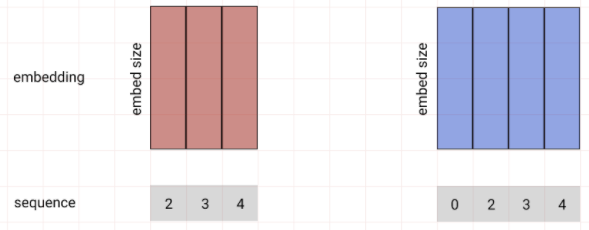

In [ ]:
src_tok=Tokenizer()

for s in df['src'].values:
  #for v in s.split(' '):#공백을 기준으로 문장 나누기, 단어됨
    src_tok.add_vocab(s)

tar_tok=Tokenizer()

for s in df['tar'].values:
  #for v in s.split(' '):
    tar_tok.add_vocab(s)


print(src_tok.vocab2index)
print(tar_tok.vocab2index)


{'': 1, 'i': 1, 'love': 2, 'you': 3, 'myself': 4, 'like': 5, 'he': 6}
{'': 1, 'ich': 1, 'liebe': 2, 'dich': 3, 'mich': 4, 'mag': 5, 'er': 6, 'liebt': 7}


In [ ]:
print(src_tok.index2vocab)
print(tar_tok.index2vocab)

{0: '', 1: 'i', 2: 'love', 3: 'you', 4: 'myself', 5: 'like', 6: 'he'}
{0: '', 1: 'ich', 2: 'liebe', 3: 'dich', 4: 'mich', 5: 'mag', 6: 'er', 7: 'liebt'}


In [ ]:
src_data=[src_tok.to_seq(s) for s in df['src'].values]
tar_data=[[SOS_token]+tar_tok.to_seq(s)+[EOS_token] for s in df['tar'].values]
#왜 타겟 문장에만 sos와 eos를 붙여주는 걸까?

print(src_data)
print(tar_data)

[[1, 2, 3], [1, 2, 4], [1, 5, 3], [6, 2, 3]]
[[0, 1, 2, 3, 1], [0, 1, 2, 4, 1], [0, 1, 5, 3, 1], [0, 6, 7, 3, 1]]


In [ ]:
#하이퍼파라미터

hparam={}
hparam['embed_size']=8

#여기서는 embedding size를 8로


# Encoder

Encoder의 내부는 Embedding 레이어와 LSTM 레이어로 이루어져 있다. 



```
torch.nn.Embedding(src_n_vocab,embed_size)
torch.nn.LSTM(input_size=embed_size,hidden_size=embed_size)
```



In [ ]:
class Encoder(nn.Module):
  def __init__(self):
    super(Encoder,self).__init__()
    self.embed=nn.Embedding(src_tok.n_vocab,hparam['embed_size'])#(7,8)
    self.rnn=nn.LSTM(input_size=hparam['embed_size'],hidden_size=hparam['embed_size'])#(8,8)

  def forward(self,x,h,c):
    #(1)
    x=self.embed(x)
    #(embed_size)
    x=x.view((1,1,-1))
    #(1,1,embed_size)
    x,(h,c)=self.rnn(x,(h,c))
    #(1,1,embed_size) (1,1,embed_size) (1,1,embed_size)
    return h,c

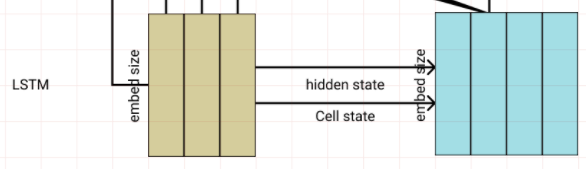

이렇게 하면 Encoder의 LSTM은 i,love,you 3 단어를 입력받고 3개의 값을 출력한다. 그리고 Decoder의 LSTM에게 hidden state와 cell state를 넘겨준다. 

Encoder에서 넘긴 state들은 encoder에서 압축된 "i love you"의 문맥과 의미정보를 Decoder에 제공한다. 

## Decoder

Decoder 또한 embedding 레이어와 LSTM 레이어로 이루어져있다. 

그 뒤에 decoder는 처음으로 sos 토큰을 입력받고, 전달받은 state를 기반으로 출력을 만든다. 



```
torch.nn.Embedding(tar_n_vocab,embed_size)
torch.nn.LSTM(input_size=embed_sizem,hidden_size=embed_size)

```



여기서 단어 리스트 사이즈랑 임베딩 사이즈를 입력한다. 

In [ ]:
class Decoder(nn.Module):
  def __init__(self):
    super(Decoder,self).__init__()
    self.embed=nn.Embedding(tar_tok.n_vocab,hparam['embed_size'])
    self.rnn=nn.LSTM(input_size=hparam['embed_size'],hidden_size=hparam['embed_size'])

  def forward(self,x,h,c):
    x=self.embed(x)
    x=x.view((1,1,-1))
    x,(h,c)=self.rnn(x,(h,c))
    return h,c

## attention score

Decoder는 다음 단어를 생성하기 위해 Encoder에 입력된 단어중 어떤 단어에 집중해야할지 점수를 매긴다. 
*논문에서는 단어+단어 주변에 focus한 정보라고 함. 


In [ ]:
class Attention(nn.Module):
  def __init__(self):
    super(Attention,self).__init__()
    self.wc=nn.Linear(hparam['embed_size']*2,hparam['embed_size'])
    self.tanh=nn.Tanh()
    self.wy=nn.Linear(hparam['embed_size'],tar_tok.n_vocab)

  def forward(self,x):
    x=self.wc(x)
    x=self.tanh(x)
    x=self.wy(x)
    x=F.log_softmax(x,dim=2)

    return x



Attention 기법은 여러가지 방법이 있는데 그 중 dot_product attention을 이용해보았따. 
t 시점의 decoder의 출력과 모든 시점의 encoder를 각기 dot연산하여 score를 구한다. 



```
# (src_len, 1, embed_size) (1,embed_size,1) 
score = enc_out.matmul(dec_out.view((1,embed_size,1)))
# t 시점 state의 encoder h attention score
# (src_len, 1, 1) = score(hn, stT)
```



LSTM에서 나온 출력은 각 단어의 의미를 함유하고 있는 벡터이다. 이러한 의미를 attention score로 어떤 출력 시점에 어떤 입력을 참고하면 좋을지 점수를 부여한다. 

그렇게 점수 매겨진 attention score를 가중치로서 곱할 수 있도록 값을 softmax로 조정한 것이 attention distribution이였다. 

이것을 다시 LSTM에서 나온 출력인 의미 벡터와 곱하는 것은 어떤 의미를 증폭시키겠다. 즉 다음 출력을 만들어 내는데 있어 이 단어에 초점을 어떤 비율만큼 두겠다라는 것이다. 

"I love you"fmf "ich liebe dich"로 번역하는 작업을 할 떄는 Decoder에 ich를 입력받은 시점에서는 liebe를 출력해야 하기에 love에 대하여 높은 가중치로 집중해야할 것이다. 

또한 번역이라는게 "sweet potato"를 "고구마"로 번역해야한다면 "고구마"를 출력해야하는 시점에서 "sweet"와 "potato"에 모두 적당한 가중치가 부여될 것이다. 

"그렇다면 attention value로 만들기 위해 sum 연산으로 합쳐버리면 의미가 소실되는 것이 아닌가에 대한 답변으로는 위의 의미 데이터는 벡터값이라 더한다고 소실되지 않으니 문제가 없다. 

### decoder hidden state

집중해야할 의미를 압축해놓은 attention value를 decoder의 현재 step의 출력과 붙여서 신경망 연산을 수행하여 시점정보돠 attention 정보를 해석한 decoder hidden state를 만든다. 

In [ ]:
encoder=Encoder()
decoder=Decoder()
attention=Attention()

enc_optimizer=optim.RMSprop(encoder.parameters(),lr=0.01)
dec_optimizer=optim.RMSprop(decoder.parameters(),lr=0.01)
att_optimizer=optim.RMSprop(attention.parameters(),lr=0.01)
criterion=nn.NLLLoss()

loss_hist=[]

for epoch in range(500):
  loss_avg=[]

  for batch in range(len(src_data)):#데이터 크기만큼 반복
    loss=0
    src_train=torch.LongTensor(src_data[batch])

    h,c=torch.zeros((1,1,hparam['embed_size'])),torch.zeros((1,1,hparam['embed_size']))
    #hidden state, cell state
    # (1,1,embed_size) (1,1,embed_size)

    enc_out=torch.Tensor([])
    #(src_len,1,embed_size)
    for i in range(len(src_train)):
      h,c=encoder(src_train[i],h,c)
      enc_out=torch.cat((enc_out,h))

    tar_train=torch.LongTensor(tar_data[batch])
#======================================================================================================
    sent=[]

    #teaching force rate
    rate=0.5

    #teaching force
    if rate>np.random.rand():
      for i in range(len(tar_train[:-1])):
        h,c=decoder(tar_train[i],h,c)
        #(1,1,embed_size) (1,1,embed_size)

        score=enc_out.matmul(h.view((1,hparam['embed_size'],1)))
        #dot product attention
        #t 시점 state의 encoder h attention score
        # (src_len, 1, 1) = score(hn, stT)
 
        att_dis=F.softmax(score,dim=0)
        #Attention Distribution
        #각 입력에 대해 얼마나 집중할지 비율 값으로 만드는 과정.
        #(src_len,1,1)

        att_v=torch.sum(enc_out*att_dis,dim=0).view(1,1,hparam['embed_size'])
        #attention value
        #encoder의 LSTM에서 각 단어들의 출력을 attention distribution을 가중치로 하여 곱하고 곱해진 값을 더하여 하나의 벡터로 합친다.
        #(1,1,embed_size)
        
        #decoder hidden state
        con=torch.cat((att_v,h),dim=2)
        #concatinate
        #(1,1,embed_size)
        out=attention(con)
        #(1,1,word_cnt)
        loss+=criterion(out.view((1,-1)),tar_train[i+1].view(1))

        sent.append(tar_tok.index2vocab[out.argmax().detach().item()]) 


    #without teaching force
    else:
      dec_in=tar_train[0]
      #scalar
      for i in range(len(tar_train[:-1])):
        h,c=decoder(dec_in,h,c)
        score=enc_out.matmul(h.view((1,hparam['embed_size'],1)))

        att_dis = F.softmax(score, dim=0)
        att_v = torch.sum(enc_out * att_dis, dim=0).view(1,1,hparam['embed_size'])
        con = torch.cat((att_v, h), dim=2)
        topv,topi=out.squeeze().topk(1)

        dec_in=topi[0].detach()
        #scalar
        loss+=criterion(out.view((1,-1)),tar_train[i+1].view(1))

        sent.append(tar_tok.index2vocab[out.argmax().detach().item()])

        if dec_in==EOS_token:
          break

      if (epoch+1)%50==0:
        print(epoch + 1, batch, loss.item())
        print(' '.join([tar_tok.index2vocab[t] for t in tar_train.detach().numpy()[1: ]]))
        print(' '.join(sent))

      enc_optimizer.zero_grad()
      dec_optimizer.zero_grad()
      att_optimizer.zero_grad()

      loss = loss / len(df)
      loss.backward()

      enc_optimizer.step()
      dec_optimizer.step()
      att_optimizer.step()

      loss_avg.append(loss.item())

    loss_hist.append(sum(loss_avg))

    if (epoch + 1) % 50 == 0:
        print('avg loss', loss_hist[-1])
        print('=============================')    


      




RuntimeError: ignored

In [ ]:

encoder = Encoder()
decoder = Decoder()
attention = Attention()

enc_optimizer = optim.RMSprop(encoder.parameters(), lr=0.01)
dec_optimizer = optim.RMSprop(decoder.parameters(), lr=0.01)
att_optimizer = optim.RMSprop(attention.parameters(), lr=0.01)
criterion = nn.NLLLoss()

loss_hist = []
for epoch in range(500):
    loss_avg = []

    for batch in range(len(src_data)):

        loss = 0

        src_train = torch.LongTensor(src_data[batch])

        h, c = torch.zeros((1, 1, hparam['embed_size'])), torch.zeros((1, 1, hparam['embed_size']))
        # (1,1,embed_size) (1,1,embed_size)

        enc_out = torch.Tensor([])
        # (src_len, 1, embed_size)
        for i in range(len(src_train)):
            # x = (1)
            h, c = encoder(src_train[i], h, c)
            # (1,1,embed_size) (1,1,embed_size)
            enc_out = torch.cat((enc_out, h))

        tar_train = torch.LongTensor(tar_data[batch])

        sent = []

        # teaching force rate
        rate = 0.5

        # teaching force
        if rate > np.random.rand():
            for i in range(len(tar_train[:-1])):
                h, c = decoder(tar_train[i], h, c)
                # (1,1,embed_size) (1,1,embed_size)
                score = enc_out.matmul(h.view((1,hparam['embed_size'],1)))
                # t 시점 state의 encoder h attention score
                # (src_len, 1, 1) = score(hn, stT)
                att_dis = F.softmax(score, dim=0)
                # Attention Distribution
                # (src_len,1,1)
                att_v = torch.sum(enc_out * att_dis, dim=0).view(1,1,hparam['embed_size'])
                # Attention Value
                # (1,1,embed_size)
                con = torch.cat((att_v, h), dim=2)
                # Concatinate
                out = attention(con)
                # (1,1,word_cnt)
                loss += criterion(out.view((1, -1)), tar_train[i+1].view(1))

                sent.append(tar_tok.index2vocab[out.argmax().detach().item()])

        # without teaching force
        else:
            dec_in = tar_train[0]
            # skalar
            for i in range(len(tar_train[:-1])):
                h, c = decoder(dec_in, h, c)
                score = enc_out.matmul(h.view((1,hparam['embed_size'],1)))
                att_dis = F.softmax(score, dim=0)
                att_v = torch.sum(enc_out * att_dis, dim=0).view(1,1,hparam['embed_size'])
                con = torch.cat((att_v, h), dim=2)
                out = attention(con)
                topv, topi = out.squeeze().topk(1) # detach!
                # (1), (1)
                dec_in = topi[0].detach()
                # skalar
                loss += criterion(out.view((1, -1)), tar_train[i+1].view(1))
                
                sent.append(tar_tok.index2vocab[out.argmax().detach().item()])
                if dec_in == EOS_token:
                    break
        
        if (epoch + 1) % 50 == 0:
            print(epoch + 1, batch, loss.item())
            print(' '.join([tar_tok.index2vocab[t] for t in tar_train.detach().numpy()[1: ]]))
            print(' '.join(sent))
        
        enc_optimizer.zero_grad()
        dec_optimizer.zero_grad()
        att_optimizer.zero_grad()

        loss = loss / len(df)
        loss.backward()

        enc_optimizer.step()
        dec_optimizer.step()
        att_optimizer.step()

        loss_avg.append(loss.item())

    loss_hist.append(sum(loss_avg))

    if (epoch + 1) % 50 == 0:
        print('avg loss', loss_hist[-1])
        print('=============================')

50 0 0.006093495525419712
ich liebe dich ich
ich
50 1 0.005865978542715311
ich liebe mich ich
ich
50 2 0.007783796638250351
ich mag dich ich
ich
50 3 0.1444193720817566
er liebt dich ich
er liebt dich ich
avg loss 0.04104066069703549
100 0 0.03061060607433319
ich liebe dich ich
ich liebe dich ich
100 1 0.002025577938184142
ich liebe mich ich
ich
100 2 0.03980765864253044
ich mag dich ich
ich mag dich ich
100 3 0.033011846244335175
er liebt dich ich
er liebt dich ich
avg loss 0.026363922224845737
150 0 0.0006901028100401163
ich liebe dich ich
ich
150 1 0.02897440455853939
ich liebe mich ich
ich liebe mich ich
150 2 0.0007609808817505836
ich mag dich ich
ich
150 3 0.0115998899564147
er liebt dich ich
er liebt dich ich
avg loss 0.010506344551686198
200 0 0.00024339574156329036
ich liebe dich ich
ich
200 1 0.009429792873561382
ich liebe mich ich
ich liebe mich ich
200 2 0.0002517383254598826
ich mag dich ich
ich
200 3 0.004099132493138313
er liebt dich ich
er liebt dich ich
avg loss 0.0035